In [2]:
import dolfin as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.integrate as si
import scipy.optimize as so

import torch
import torch.nn as nn
import torch.nn.functional as F

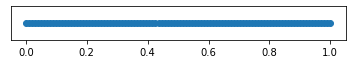

In [9]:
# number of elements
n = 101

# degree of finite element basis functions
# 1-represents piecewise linear basis functions
# 2-represents piecewise quadratic basis functions
d = 1

# Create mesh and define function space
mesh = dl.UnitIntervalMesh(n)

# Define the function space
Vh = dl.FunctionSpace(mesh, 'Lagrange', d)

# Define the exact solution
u_true = dl.Expression('0.5*x[0]*(1.0-x[0])', degree=2)

# Show the mesh
dl.plot(mesh)
plt.show()

In [ ]:
def ud_boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
ud = dl.Constant('0.0')
bc = dl.DirichletBC(Vh, ud, ud_boundary)


# Define variational problem
uh = dl.TrialFunction(Vh)
vh = dl.TestFunction(Vh)
f = dl.Constant(1.0)
a = dl.inner(dl.grad(uh), dl.grad(vh))*dl.dx
L = f*vh*dl.dx

In [3]:
# now pretend we don't know the vector field but we want to learn it
# set up a neural network model for f
nlayers = 2

# units per hidden layer
uphl = 3

# dimension of vector field
vfd = 1

# set up neural network parameters
layerwidths = [vfd,uphl,vfd]
numparams = 0
numweights = 0
numbiases = 0
for j in range(nlayers):
    numparams += layerwidths[j]*layerwidths[j+1] + layerwidths[j+1]
    numweights += layerwidths[j]*layerwidths[j+1]
    numbiases += layerwidths[j+1]

# print out total number of parameters
print(numparams)

# definition of actual neural network function
def neuralf(x, theta):
    filt = []
    si = 0
    ei = layerwidths[0]*layerwidths[1]
    filt.append( theta[si:ei].reshape((layerwidths[0],layerwidths[1])) )
    si += layerwidths[0]*layerwidths[1]
    ei += layerwidths[1]*layerwidths[2]
    filt.append( theta[si:ei].reshape((layerwidths[1],layerwidths[2])) )
    bias = []
    si += layerwidths[1]*layerwidths[2]
    ei += layerwidths[1]
    bias.append( theta[si:ei] )
    si += layerwidths[1]
    ei += layerwidths[2]
    bias.append( theta[si:ei] )
    inplyr = x
    h1 = nn.SELU( inplyr @ filt[0] + bias[0] )
    h2 = h1 @ filt[1] + bias[1] 
    return h2

10


In [7]:
# random initializer
def glorotinit():
    theta = []
    theta.append( np.random.uniform(0,1,size=layerwidths[0]*layerwidths[1]) )
    theta.append( np.random.uniform(0,1,size=layerwidths[1]*layerwidths[2]) )
    theta.append( np.zeros(numbiases) )
    theta = np.concatenate(theta)
    return theta

theta0 = glorotinit()

In [8]:
theta0

array([0.61750599, 0.71664432, 0.99073968, 0.11212256, 0.71447298,
       0.19448867, 0.        , 0.        , 0.        , 0.        ])

In [ ]:
# trust region optimizer with SR1 update
res = so.minimize(fun=objSP, jac=gradSP, x0=theta0, method='BFGS', 
                  options={'gtol': 1e-6, 'disp': True})